## Libraries

In [10]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from random import shuffle
import cv2 as cv


import matplotlib.pyplot as plt

# model
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Flatten, 
                                     Dense, 
                                     BatchNormalization, 
                                     Dropout
                                     )

### 옵티마이저 아담 ###
from tensorflow.keras.optimizers import Adam

### 얼리스탑 ###
from tensorflow.keras.callbacks import EarlyStopping

## Read the Data

### 01. mk def test 
<< 함수 구현을 위한 test 블럭입니다. 재현시 아래 02.mk def 부터 실행하세요 >>

In [2]:
cur_dir = os.getcwd()

In [41]:
img_path = "./archive02/garbage_classification/"
label_list = os.listdir(img_path) 

In [23]:
img_path_list = list()

for _ in label_list:
    img_path_list.append(img_path + _)

In [45]:
img_list = list()

for _ in label_list:
    img_list.append(os.listdir(img_path + _))

green-glass


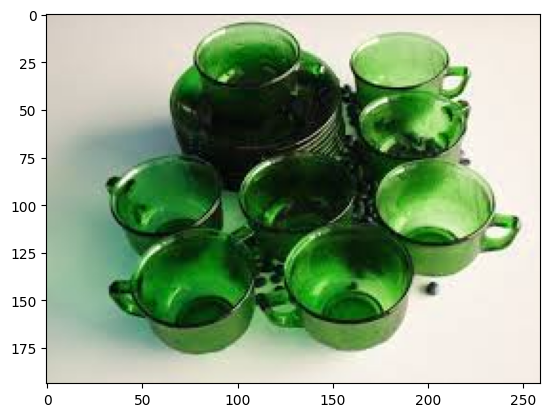

In [89]:
label = img_path_list[5].split('/')[-1]
print(label)
img = cv.imread(img_path_list[5] + "/" + img_list[5][200])
plt.imshow(img)

### 02. mk def

In [2]:
def load_lmg(img_path_list, img_list):
    train_img = list()
    test_img = list()

    for path_num in range(len(img_path_list)):
        for img_num in range(0, int(len(img_list[path_num]) * 0.8)): ### split 0.8 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            train = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            train = cv.resize(train, (64, 64))
            train = cv.cvtColor(train, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            train_img.append([np.array(train) / 255.0, np.array(label)])

    for path_num in range(len(img_path_list)):
        for img_num in range(int(len(img_list[path_num]) * 0.8) + 1, len(img_list[path_num])): ### split 0.2 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            test = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            test = cv.resize(test, (64, 64))
            test = cv.cvtColor(test, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            test_img.append([np.array(test) / 255.0, np.array(label)])

    
    return train_img, test_img

In [3]:
cur_dir = os.getcwd()
img_path = "./archive02/garbage_classification/"
label_list = os.listdir(img_path) 

In [4]:
img_path_list = list()
img_list = list()

for _ in label_list:
    img_path_list.append(img_path + _)

for _ in label_list:
    img_list.append(os.listdir(img_path + _))

In [5]:
train_img, test_img = load_lmg(img_path_list, img_list)

In [6]:
print(f"=============\nDataset\n=============\ntrain: {len(train_img)}\ntest: {len(test_img)}")

Dataset
train: 12409
test: 3094


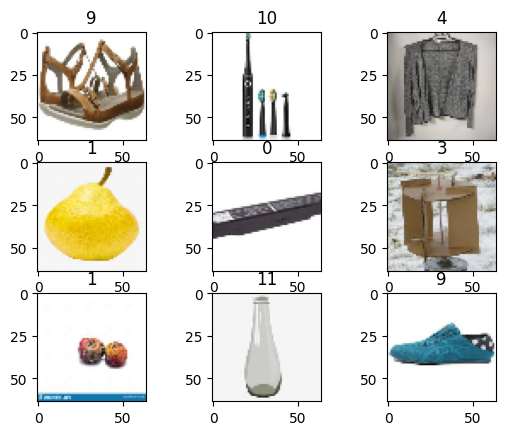

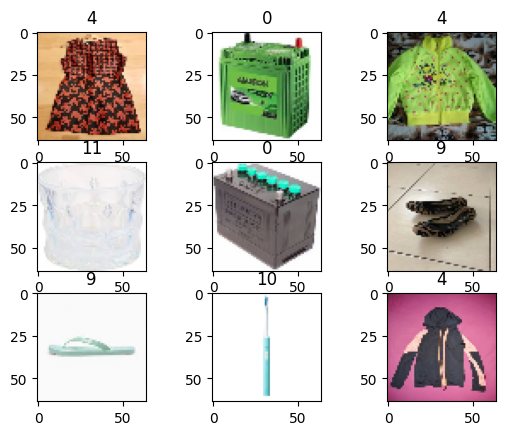

In [7]:
import random
ran_num = random.sample(range(1, 12409), 9)
ran_num_test = random.sample(range(1, 3094), 9)

i = 0
for _ in ran_num:
    i += 1
    plt.subplot(3, 3, i)
    plt.imshow(train_img[_][0])
    plt.title(train_img[_][1])
plt.show()

i = 0
for _ in ran_num_test:
    i += 1
    plt.subplot(3, 3, i)
    plt.imshow(test_img[_][0])
    plt.title(test_img[_][1])
plt.show()

> test

## Model - Prototype

In [11]:
train_images = np.array([item[0] for item in train_img])
train_labels = np.array([item[1] for item in train_img])
test_images = np.array([item[0] for item in test_img])
test_labels = np.array([item[1] for item in test_img])

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(12409).batch(128) 

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(1000)

model = Sequential([
    ### layer 1 ###
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 2 ###
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.2),
    ### layer 3 ###
    Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.2),
    ### layer 4 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 5 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 6 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.2),
  
    Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(12, activation = 'softmax')
])

optimizer = Adam(learning_rate=0.0002)

early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_dataset, epochs = 100, validation_data = test_dataset, callbacks=[early_stopping], verbose = 1)

Epoch 1/100
97/97 [==============================] - 49s 484ms/step - loss: 16.8470 - accuracy: 0.4579 - val_loss: 17.0200 - val_accuracy: 0.3439
Epoch 2/100
97/97 [==============================] - 46s 479ms/step - loss: 15.0870 - accuracy: 0.6034 - val_loss: 16.3722 - val_accuracy: 0.3439
Epoch 3/100
97/97 [==============================] - 47s 482ms/step - loss: 13.6021 - accuracy: 0.6453 - val_loss: 15.8059 - val_accuracy: 0.3613
Epoch 4/100
97/97 [==============================] - 47s 481ms/step - loss: 12.2053 - accuracy: 0.6760 - val_loss: 14.8144 - val_accuracy: 0.3442
Epoch 5/100
97/97 [==============================] - 47s 481ms/step - loss: 10.9154 - accuracy: 0.7052 - val_loss: 12.3735 - val_accuracy: 0.3895
Epoch 6/100
97/97 [==============================] - 47s 483ms/step - loss: 9.7501 - accuracy: 0.7261 - val_loss: 10.9222 - val_accuracy: 0.4095
Epoch 7/100
97/97 [==============================] - 76s 784ms/step - loss: 8.7034 - accuracy: 0.7473 - val_loss: 9.6916 - va

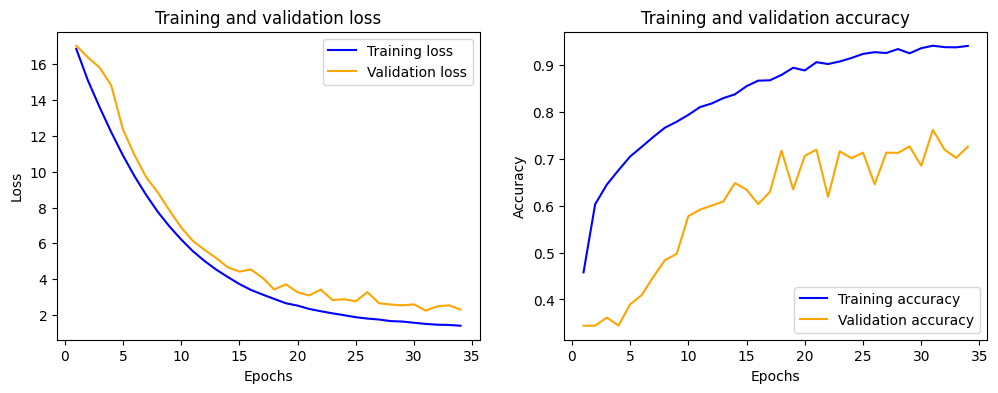

In [12]:
### 시각화 ###

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, color="blue", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, color="blue", label='Training accuracy')
plt.plot(epochs, val_accuracy, color="orange", label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Data Augmentation

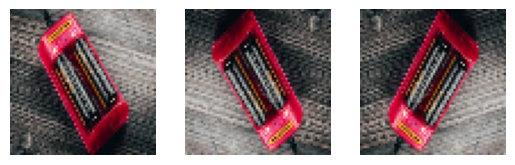

In [23]:
plt.subplot(1, 3, 1)
plt.imshow(train_img[2][0][:,::-1])
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(train_img[2][0][::-1, :])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(train_img[2][0][::-1,::-1])
plt.axis("off")

plt.show()

In [ ]:
def load_lmg(img_path_list, img_list):
    train_img = list()
    test_img = list()

    for path_num in range(len(img_path_list)):
        for img_num in range(0, int(len(img_list[path_num]) * 0.8)): ### split 0.8 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            train = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            train = cv.resize(train, (64, 64))
            train = cv.cvtColor(train, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            train_img.append([np.array(train) / 255.0, np.array(label)])

    for path_num in range(len(img_path_list)):
        for img_num in range(0, int(len(img_list[path_num]) * 0.8)): ### split 0.8 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            train = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            train = cv.resize(train, (64, 64))
            train = cv.cvtColor(train, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            train_img.append([np.array(train) / 255.0, np.array(label)])

    for path_num in range(len(img_path_list)):
        for img_num in range(0, int(len(img_list[path_num]) * 0.8)): ### split 0.8 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            train = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            train = cv.resize(train, (64, 64))
            train = cv.cvtColor(train, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            train_img.append([np.array(train) / 255.0, np.array(label)])


    for path_num in range(len(img_path_list)):
        for img_num in range(int(len(img_list[path_num]) * 0.8) + 1, len(img_list[path_num])): ### split 0.2 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            test = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            test = cv.resize(test, (64, 64))
            test = cv.cvtColor(test, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            test_img.append([np.array(test) / 255.0, np.array(label)])

    
    return train_img, test_img

In [ ]:
cur_dir = os.getcwd()
img_path = "./archive02/garbage_classification/"
label_list = os.listdir(img_path) 
    

img_path_list = list()
img_list = list()

for _ in label_list:
    img_path_list.append(img_path + _)

for _ in label_list:
    img_list.append(os.listdir(img_path + _))

In [ ]:
### 함수 실행 코드 ###
train_img, test_img = load_lmg(img_path_list, img_list)

In [ ]:
print(f"=============\nDataset\n=============\ntrain: {len(train_img)}\ntest: {len(test_img)}")

In [ ]:
import random
ran_num = random.sample(range(1, 12409), 9)
ran_num_test = random.sample(range(1, 3094), 9)

i = 0
for _ in ran_num:
    i += 1
    plt.subplot(3, 3, i)
    plt.imshow(train_img[_][0])
    plt.title(train_img[_][1])
plt.show()

i = 0
for _ in ran_num_test:
    i += 1
    plt.subplot(3, 3, i)
    plt.imshow(test_img[_][0])
    plt.title(test_img[_][1])
plt.show()